In [1]:
# Import Data handling/display libraries
import pandas  as pd
import numpy   as np
import seaborn as sns
sns.set()
sns.set_context("talk")
import matplotlib.pyplot as plt
from IPython.display import display
from typing import List, Union, Dict
# Import scikit-learn core slibraries
from sklearn.metrics         import auc, roc_auc_score, roc_curve
from sklearn.metrics         import classification_report, confusion_matrix
from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import RandomForestClassifier
from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import train_test_split
from collections             import Counter
# Import IBM's AI Fairness tooolbox
from aif360.datasets   import BinaryLabelDataset  # To handle the data
from aif360.metrics    import BinaryLabelDatasetMetric, ClassificationMetric  # For calculating metrics
from aif360.explainers import MetricTextExplainer  # For explaining metrics
from aif360.algorithms import Transformer
from aif360.algorithms.preprocessing import DisparateImpactRemover # Preprocessing technique
# Warnings will be used to silence various model warnings for tidier output
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the cleaned Taiwan-Credit-Card-Cleaned-Marriage dataset
Taiwan_df = pd.read_csv('./input/Taiwan-Credit-Card-Cleaned-Marriage.csv')
Taiwan_df.head(1)

,LIMIT_BAL,GENDER,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,20000.0,2.0,2.0,1.0,24.0,2.0,2.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Set privileged (1)/ unprivileged (0)/ favourable (1) / unfavourable values (0)
protected_attr      = 'MARRIAGE'
priv_grp            = 1  # Married males and females 
unpriv_grp          = 0  # Single males and females  
lab                 = 'DEFAULT'
fav_label           = 1 # Will not default next month
unfav_label         = 0 # Will default next month
privileged_groups   = [{protected_attr: priv_grp}]   # Married folk (male and female)
unprivileged_groups = [{protected_attr: unpriv_grp}] # Single folk  (male and female)

In [4]:
# Establish logistic Regression, Random Forest and Binary Label Dataset performance baselines
# Create the training and test data sets
X = Taiwan_df.drop(lab,axis=1)
y = Taiwan_df[lab]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

In [5]:
# Scale the training and test data
scaler = MinMaxScaler(copy=False)
X_train = pd.DataFrame(scaler.fit_transform(X_train.values), columns=X_train.columns, index=X_train.index)
X_test  = pd.DataFrame(scaler.fit_transform(X_test.values),  columns=X_test.columns,  index=X_test.index)

In [6]:
biasedlogmodel = LogisticRegression(random_state=101)
biasedlogmodel.fit(X_train,y_train)
logpredictions = biasedlogmodel.predict(X_test)
print(f"Logistic regression validation accuracy: {biasedlogmodel.score(X_test, y_test)}")

Logistic regression validation accuracy: 0.8168776371308016


In [7]:
biasedrfcmodel = RandomForestClassifier(n_estimators=100,max_depth=4)
biasedrfcmodel.fit(X_train, y_train)
rfcpredictions = biasedrfcmodel.predict(X_test)
print(f"Random forest validation accuracy: {biasedrfcmodel.score(X_test, y_test)}")

Random forest validation accuracy: 0.8033755274261604


In [8]:
# Create a Binary Label Dataset to use with AIF360 APIs
Taiwan_bld = BinaryLabelDataset(df=pd.concat((X, y), axis=1),
                                label_names=[lab], protected_attribute_names=[protected_attr],
                                favorable_label=fav_label, unfavorable_label=unfav_label)
privileged_groups   = [{protected_attr: priv_grp}]   # Married folk (male and female)
unprivileged_groups = [{protected_attr: unpriv_grp}] # Single folk  (male and female)

In [35]:
# Look at the metrics of this DI removed binary labelled dataset
# Now look at the baseline bias metrics from the binary labelled dataset
# Create the metric object from the Binary Label Dataset.
metric_train_bld = BinaryLabelDatasetMetric(Taiwan_bld,
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)
print('Number of instances           :', metric_train_bld.num_instances())
print('Base Rate                     :', metric_train_bld.base_rate())
print('Consistency                   :', metric_train_bld.consistency())
print('Disparate Impact              :', metric_train_bld.disparate_impact())
print('Mean Difference               :', metric_train_bld.mean_difference())
print('Statistical Parity Difference :', metric_train_bld.statistical_parity_difference()) 
print('# of positives(privileged)    :', metric_train_bld.num_positives(privileged=True))
print('# of positives(non-privileged):', metric_train_bld.num_positives(privileged=False))
print('Total positive instances"     :', metric_train_bld.num_positives(privileged=True)+metric_train_bld.num_positives(privileged=False))
print('# of negatives(privileged)    :', metric_train_bld.num_negatives(privileged=True))
print('# of negatives(non-privileged):', metric_train_bld.num_negatives(privileged=False))
print('Total negative instances"     :', metric_train_bld.num_negatives(privileged=True)+metric_train_bld.num_negatives(privileged=False))

Number of instances           : 29623.0
Base Rate                     : 0.778989298855619
Consistency                   : [0.75171995]
Disparate Impact              : 1.0332343067510816
Mean Difference               : 0.02543364876411569
Statistical Parity Difference : 0.02543364876411569
# of positives(privileged)    : 10453.0
# of positives(non-privileged): 12623.0
Total positive instances"     : 23076.0
# of negatives(privileged)    : 3206.0
# of negatives(non-privileged): 3341.0
Total negative instances"     : 6547.0


In [9]:
# Split the Binary Labelled Dataset into train, test =
train, test = Taiwan_bld.split([0.8],shuffle=True)

In [10]:
scaler = MinMaxScaler(copy=False)
train.features = scaler.fit_transform(train.features)
test.features  = scaler.fit_transform(test.features)
protected=protected_attr
index = train.feature_names.index(protected_attr)
index

3

In [11]:
from tqdm import tqdm
DIs = []
for level in tqdm(np.linspace(0., 1., 11)):
    di = DisparateImpactRemover(repair_level=level)
    train_repd = di.fit_transform(train)
    test_repd = di.fit_transform(test)
    
    X_tr = np.delete(train_repd.features, index, axis=1) # delete MARRIAGE
    X_te = np.delete(test_repd.features, index, axis=1)  # delete MARRIAGE
    y_tr = train_repd.labels.ravel()
    
    lmod = LogisticRegression(class_weight='balanced', solver='liblinear')
    lmod.fit(X_tr, y_tr)
    
    test_repd_pred = test_repd.copy()
    test_repd_pred.labels = lmod.predict(X_te)

    cm = BinaryLabelDatasetMetric(test_repd_pred, privileged_groups=privileged_groups, 
                                  unprivileged_groups=unprivileged_groups)
    DIs.append(cm.disparate_impact())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [02:38<00:00, 13.06s/it]


<IPython.core.display.Javascript object>


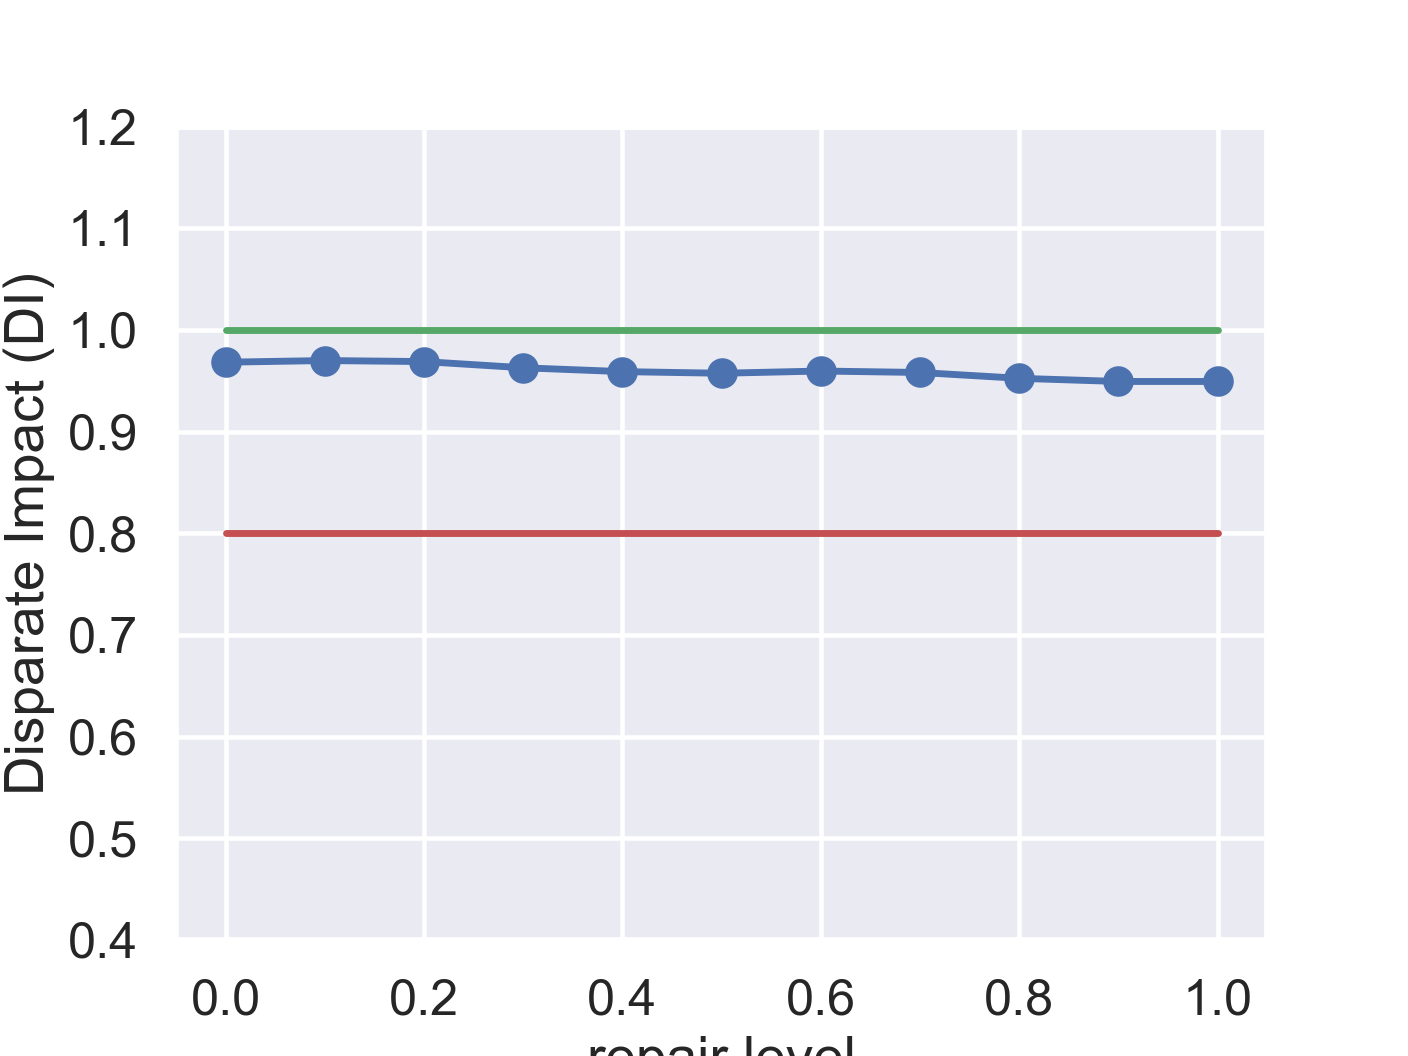

In [12]:
%matplotlib notebook

plt.plot(np.linspace(0, 1, 11), DIs, marker='o')
plt.plot([0, 1], [1, 1], 'g')
plt.plot([0, 1], [0.8, 0.8], 'r')
plt.ylim([0.4, 1.2])
plt.ylabel('Disparate Impact (DI)')
plt.xlabel('repair level')
plt.show()

In [13]:
#Where the plot is closest to 1 or the 0.8 (threshold) line is where we target, eg level = 0.0
# Therefore set up an instance of the disparate remover object using this repair level.
di = DisparateImpactRemover(repair_level=0.0)

In [14]:
# Fit the disparate remover on the original binary labelled dataset
# Returns a binary labelled dataset
Taiwan_di_removed_bld = di.fit_transform(Taiwan_bld)

In [15]:
#Convert the returned Binary Labelled Dataset to a pandas dataframe 
Taiwan_di_removed_df, d = Taiwan_di_removed_bld.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=False)

In [16]:
# Check whether the transform on the original dataset has worked. 
# A false means that the dataset is transformed.
Taiwan_di_removed_df.equals(Taiwan_df)

False

In [17]:
#Taiwan_di_removed_df.head(3)

In [18]:
#Taiwan_df.head(3)

In [19]:
# Let's take a look at the differences between the original dataset and the DI_removed dataset
Taiwan_df           = Taiwan_df.reset_index(drop=True)
Taiwan_di_removed_df = Taiwan_di_removed_df.reset_index(drop=True)
TaiwanBool   = (Taiwan_df != Taiwan_di_removed_df).stack()  # Create Frame of comparison booleans
Taiwandiff   = pd.concat([Taiwan_df.stack()[TaiwanBool], Taiwan_di_removed_df.stack()[TaiwanBool]], axis=1)
Taiwandiff.columns=["Taiwan_df", "Taiwan_removed_df"]
print(Taiwandiff)

Empty DataFrame
Columns: [Taiwan_df, Taiwan_removed_df]
Index: []


In [20]:
Taiwandiff.shape

(0, 2)

In [21]:
# Create the training and test data sets from the Adult_di_removed_df transformed dataframe
X_di = Taiwan_di_removed_df.drop(lab,axis=1)
y_di = Taiwan_di_removed_df[lab]
X_di_train, X_di_test, y_di_train, y_di_test = train_test_split(X_di, y_di, test_size = 0.2, random_state = 101)

In [22]:
scaler = MinMaxScaler(copy=False)
X_di_train = pd.DataFrame(scaler.fit_transform(X_di_train.values),columns=X_di_train.columns, index=X_di_train.index)
X_di_test  = pd.DataFrame(scaler.fit_transform(X_di_test.values), columns=X_di_test.columns,  index=X_di_test.index)

In [23]:
# Recreate the DI Removed binary labelled data set if required
Taiwan_di_removed_bld = BinaryLabelDataset(df=pd.concat((X_di_train, y_di_train), axis=1),
                                label_names=[lab], protected_attribute_names=[protected_attr],
                                favorable_label=fav_label, unfavorable_label=unfav_label)
privileged_groups   = [{protected_attr: priv_grp}]   # Married folk (male and female)
unprivileged_groups = [{protected_attr: unpriv_grp}] # Single folk  (male and female)

In [24]:
# Look at the metrics of this DI removed binary labelled dataset
# Now look at the baseline bias metrics from the binary labelled dataset
# Create the metric object from the Binary Label Dataset.
metric_train_bld = BinaryLabelDatasetMetric(Taiwan_di_removed_bld,
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)
print('Number of instances           :', metric_train_bld.num_instances())
print('Base Rate                     :', metric_train_bld.base_rate())
print('Consistency                   :', metric_train_bld.consistency())
print('Disparate Impact              :', metric_train_bld.disparate_impact())
print('Mean Difference               :', metric_train_bld.mean_difference())
print('Statistical Parity Difference :', metric_train_bld.statistical_parity_difference()) 
print('# of positives(privileged)    :', metric_train_bld.num_positives(privileged=True))
print('# of positives(non-privileged):', metric_train_bld.num_positives(privileged=False))
print('Total positive instances"     :', metric_train_bld.num_positives(privileged=True)+metric_train_bld.num_positives(privileged=False))
print('# of negatives(privileged)    :', metric_train_bld.num_negatives(privileged=True))
print('# of negatives(non-privileged):', metric_train_bld.num_negatives(privileged=False))
print('Total negative instances"     :', metric_train_bld.num_negatives(privileged=True)+metric_train_bld.num_negatives(privileged=False))

Number of instances           : 23698.0
Base Rate                     : 0.7808675837623428
Consistency                   : [0.7831125]
Disparate Impact              : 1.0325233719294622
Mean Difference               : 0.024958619151072337
Statistical Parity Difference : 0.024958619151072337
# of positives(privileged)    : 8377.0
# of positives(non-privileged): 10128.0
Total positive instances"     : 18505.0
# of negatives(privileged)    : 2539.0
# of negatives(non-privileged): 2654.0
Total negative instances"     : 5193.0


In [25]:
unbiasedlogmodel = LogisticRegression(random_state=101)
unbiasedlogmodel.fit(X_di_train,y_di_train)
logpredictions = unbiasedlogmodel.predict(X_di_test)
print(f"biased Logistic regression validation accuracy: {biasedlogmodel.score(X_test, y_test)}")
print(f"Unbiased Logistic regression validation accuracy: {unbiasedlogmodel.score(X_di_test, y_di_test)}")

biased Logistic regression validation accuracy: 0.8168776371308016
Unbiased Logistic regression validation accuracy: 0.8168776371308016


In [26]:
# Now train Random Forest Classifier to establish the DI_Removed performance
unbiasedrfcmodel = RandomForestClassifier(n_estimators=100, max_depth=4)
unbiasedrfcmodel.fit(X_di_train, y_di_train) 
rfcpredictions = unbiasedrfcmodel.predict(X_di_test)
print(f"biased Random Forest validation accuracy: {biasedrfcmodel.score(X_test, y_test)}")
print(f"Unbiased Random Forest validation accuracy: {unbiasedrfcmodel.score(X_di_test, y_di_test)}")

biased Random Forest validation accuracy: 0.8033755274261604
Unbiased Random Forest validation accuracy: 0.8032067510548523


Accuracy:


,LogReg,RFC
Unfair,0.816878,0.803376
Fair,0.816878,0.803207


AUC:


<IPython.core.display.Javascript object>


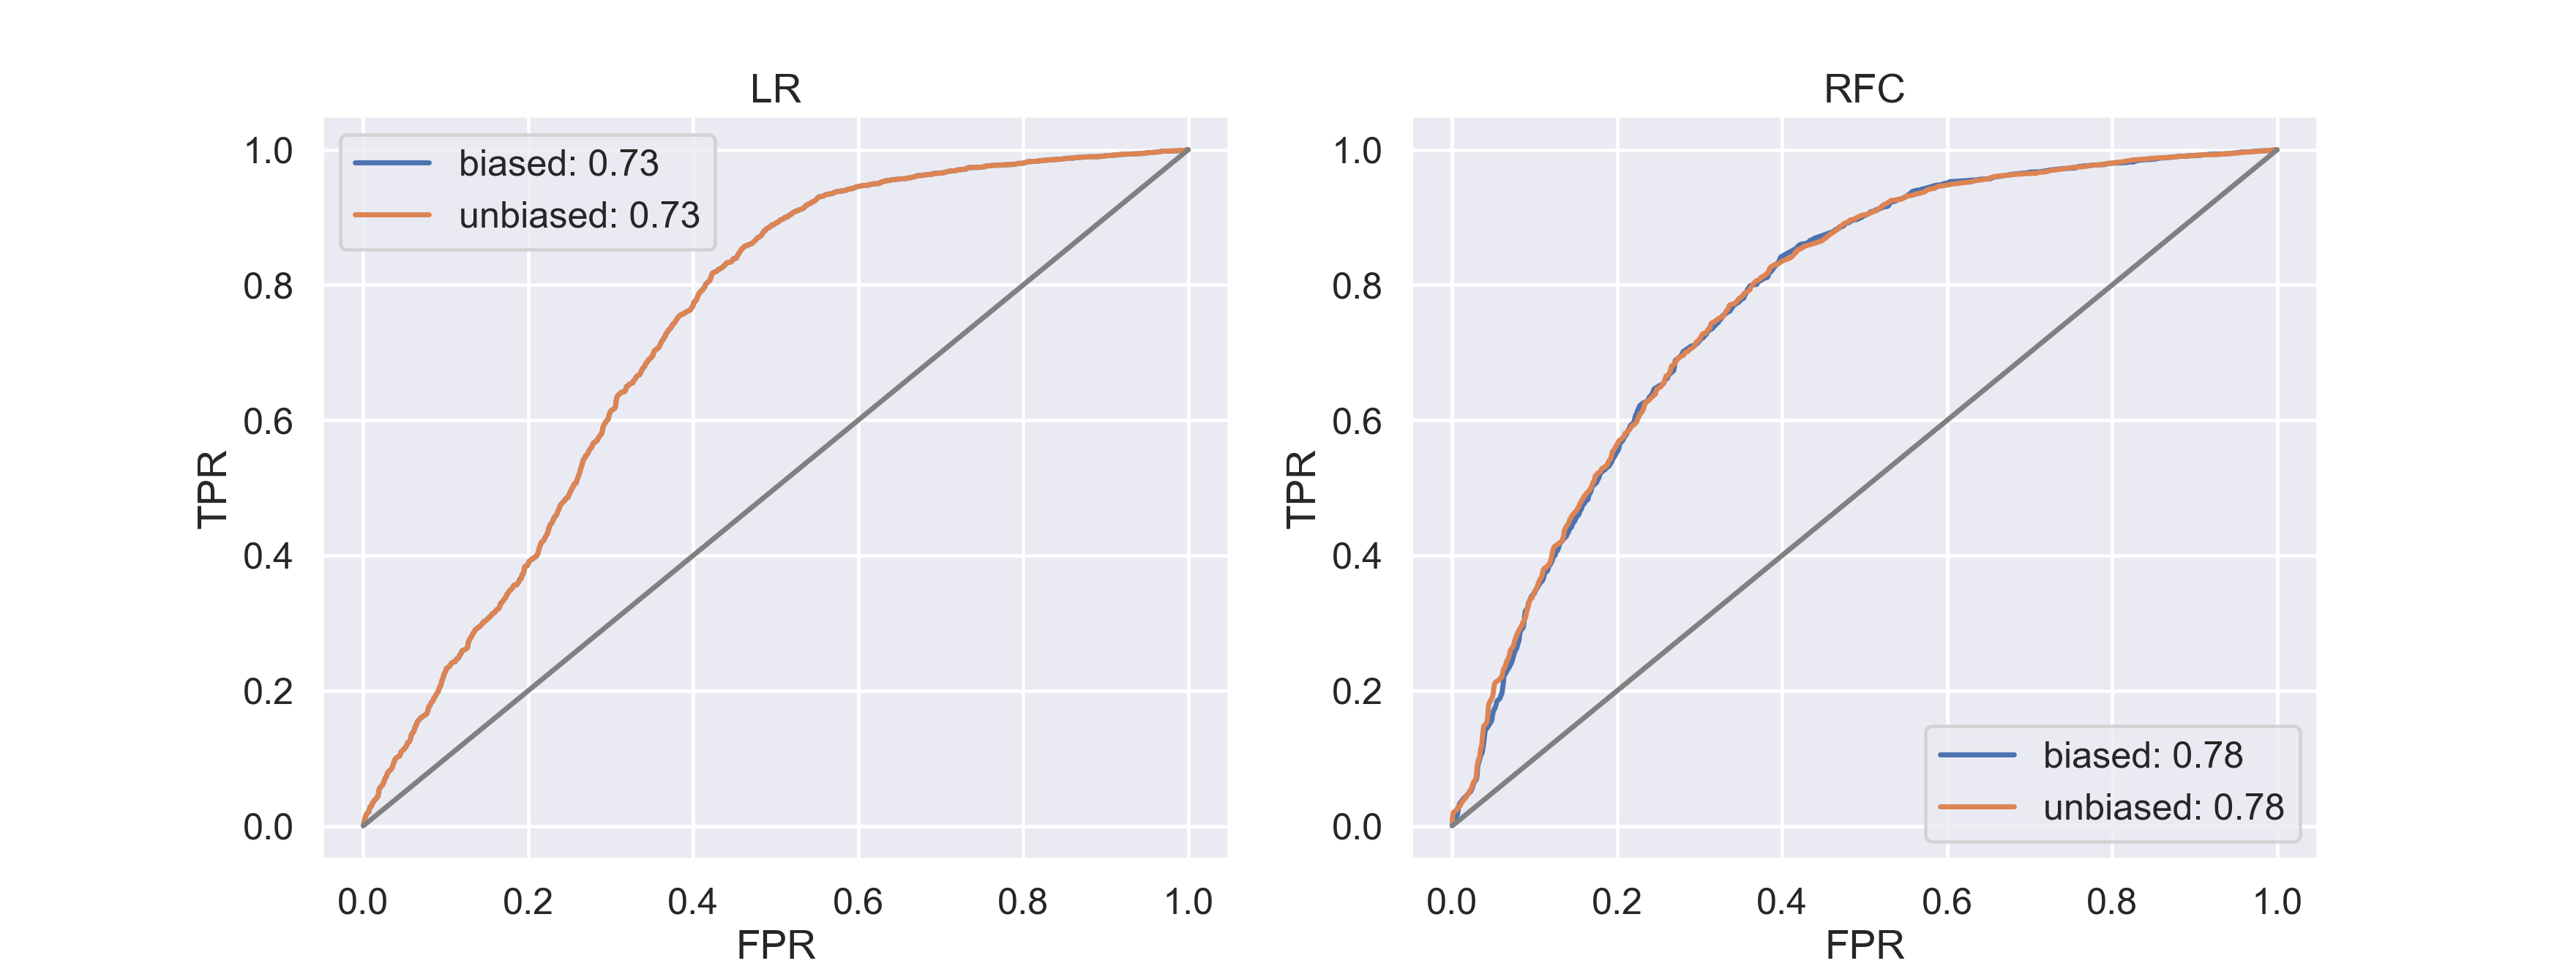

In [27]:
def plot_auc(y_true: np.ndarray, preds: Dict[str, np.ndarray],
             title: str='', 
             ax=None) -> None:
    leg = []
    for k, p in preds.items():
        fpr, tpr, _ = roc_curve(y_true, p)
        ax = sns.lineplot(x=fpr, 
                          y=tpr,
                          ci=None,
                          ax=ax
                         )
        leg.append(f"{k}: {round(auc(fpr, tpr), 2)}")
   
    ax.legend(leg)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    sns.lineplot(x=[0, 1],
                 y=[0, 1],
                 color='gray',
                 ax=ax)
    
    ax.set_title(title)
    
print('Accuracy:')
display(pd.DataFrame({'LogReg': [biasedlogmodel.score(X_test, y_test), 
                                 unbiasedlogmodel.score(X_di_test, y_di_test)],
                      'RFC': [biasedrfcmodel.score(X_test, y_test),
                              unbiasedrfcmodel.score(X_di_test, y_di_test)]}, 
                     index =['Unfair', 'Fair']))

print('AUC:')
fig, ax = plt.subplots(nrows=1, 
                       ncols=2,
                       figsize=(16, 6))
plot_auc(y_test, 
         {'biased': biasedlogmodel.predict_proba(X_test)[:, 1],
          'unbiased': unbiasedlogmodel.predict_proba(X_di_test)[:, 1]},
         title='LR',
         ax=ax[0]) 
plot_auc(y_test, 
         {'biased': biasedrfcmodel.predict_proba(X_test)[:, 1],
          'unbiased': unbiasedrfcmodel.predict_proba(X_di_test)[:, 1]},
         title='RFC',
         ax=ax[1]) 
plt.show()

In [28]:
def feature_importance(mod: Union[LogisticRegression, RandomForestClassifier],
                       names: List[str],
                       scale=None) -> pd.DataFrame:
    """Return feature importance for LR or RFC models in a sorted DataFrame."""
    if type(mod) == LogisticRegression:
        imp = np.abs(mod.coef_.squeeze()) / scale
        var = np.zeros(shape=imp.shape)
    elif type(mod) == RandomForestClassifier:
        imps = np.array([fi.feature_importances_ for fi in mod.estimators_])
        imp = imps.mean(axis=0)
        var = imps.std(axis=0)

    return pd.DataFrame({'feature': names,
                         'importance': imp,
                         'std': var}).sort_values('importance',
                                                  ascending=False)

def plot_feature_importance(**kwargs) -> None:
    ax = sns.barplot(**kwargs)
    for l in ax.get_xticklabels():
        l.set_rotation(90)

<IPython.core.display.Javascript object>


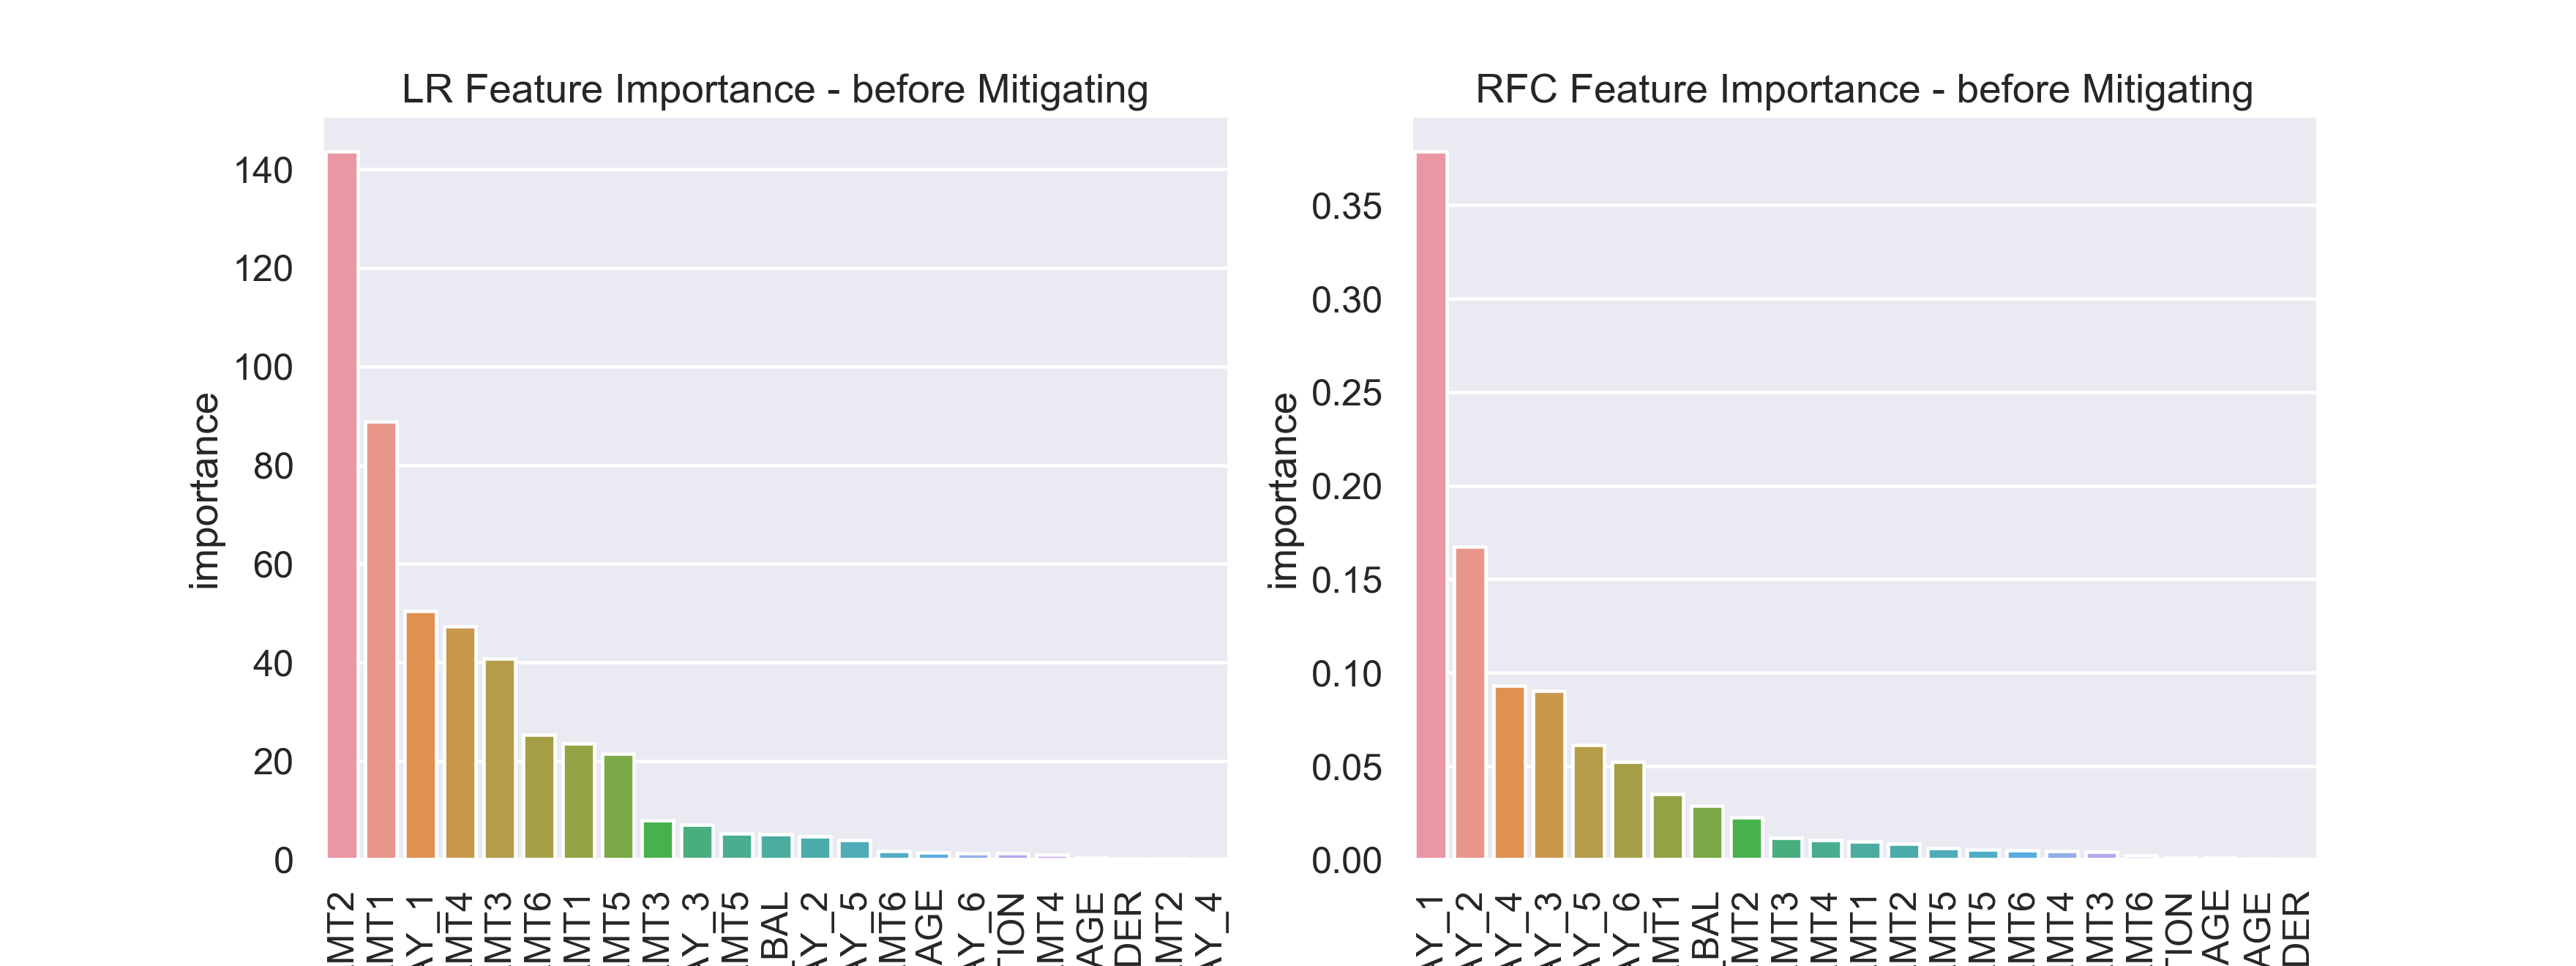

In [29]:
fig, ax = plt.subplots(nrows=1, 
                       ncols=2,
                       figsize=(16, 6))

plot_feature_importance(x='feature', 
                        y='importance', 
                        data=feature_importance(biasedlogmodel,
                                                names=X_train.columns.tolist(),
                                                scale=X_train.std()),
                       ax=ax[0])
_ = ax[0].set_title('LR Feature Importance - before Mitigating')
plot_feature_importance(x='feature', 
                        y='importance', 
                        data=feature_importance(biasedrfcmodel,
                                                names=X_di_train.columns.tolist()),
                       ax=ax[1])
_ = ax[1].set_title('RFC Feature Importance - before Mitigating')

<IPython.core.display.Javascript object>


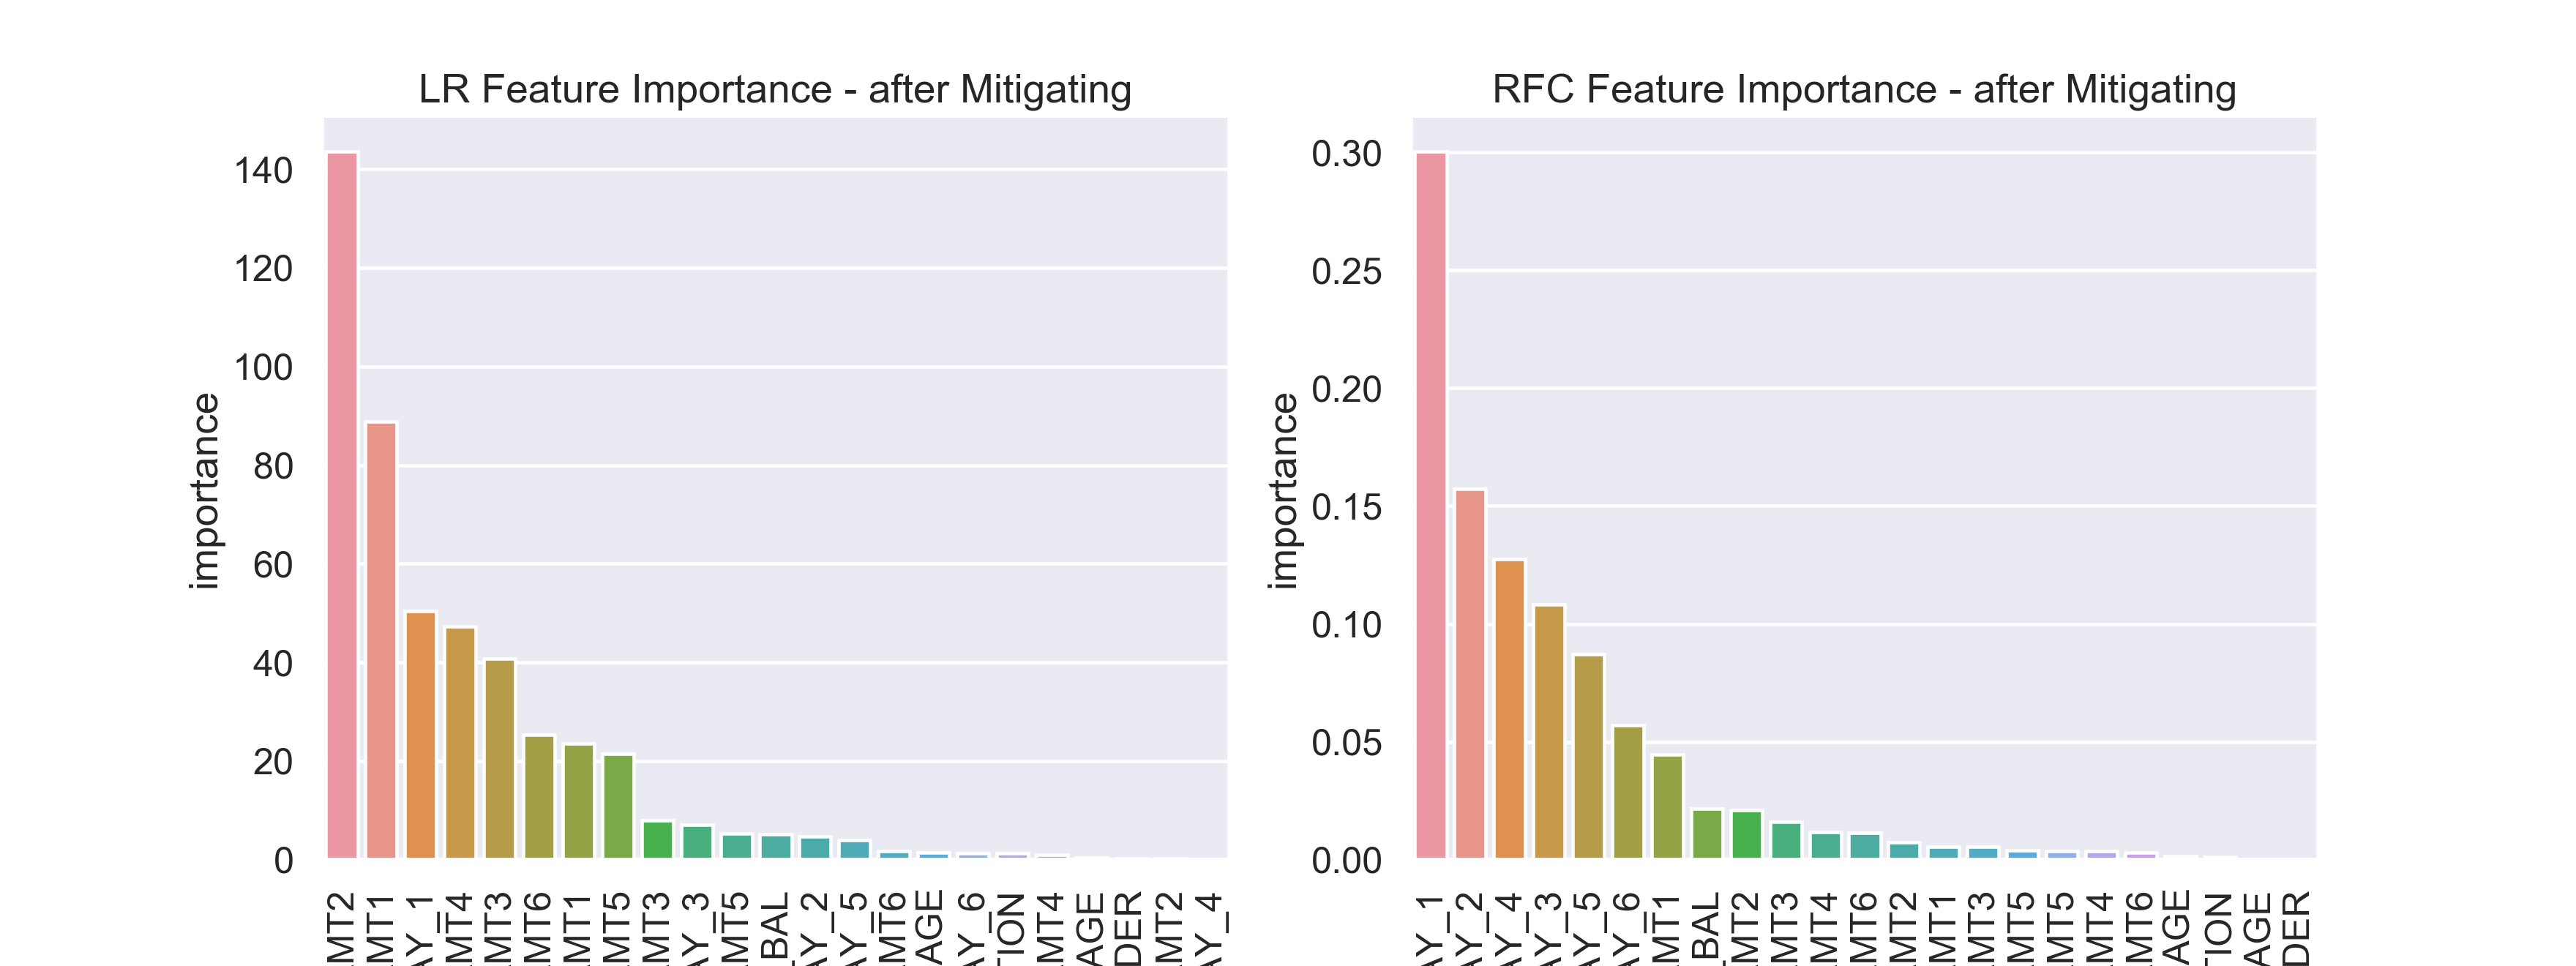

In [30]:
fig, ax = plt.subplots(nrows=1, 
                       ncols=2,
                       figsize=(16, 6))

plot_feature_importance(x='feature', 
                        y='importance', 
                        data=feature_importance(unbiasedlogmodel,
                                                names=X_train.columns.tolist(),
                                                scale=X_train.std()),
                       ax=ax[0])
_ = ax[0].set_title('LR Feature Importance - after Mitigating')
plot_feature_importance(x='feature', 
                        y='importance', 
                        data=feature_importance(unbiasedrfcmodel,
                                                names=X_di_train.columns.tolist()),
                       ax=ax[1])
_ = ax[1].set_title('RFC Feature Importance - after Mitigating')

In [31]:
def calc_metrics(mod, x: pd.DataFrame, y_true: pd.DataFrame) -> pd.DataFrame:
    """Calculate fairness metrics at each model threshold."""
    
    # Create a BinaryLabelDataset (as before training)
    bld = BinaryLabelDataset(df=pd.concat((x, y_true),axis=1),label_names=[lab],
                                  protected_attribute_names=[protected_attr],
                                  favorable_label=fav_label,
                                  unfavorable_label=unfav_label)
        
    # Create a second set to hold the predicted labels
    bld_preds = bld.copy(deepcopy=True)
    preds = mod.predict_proba(x)[:, 1] # for all the rows, retain the 2nd value.
                                       # preds will contain a single column table of all 
                                       # probabilities that the classification will be 1.
    accuracy          = []
    balanced_accuracy = []
    disp_impact       = []
    average_abs_odds_difference = []
    avg_odd_diff      = []
    equal_opportunity_difference = []
    error_rate        = []
    
    # For threshold values between 0 and 1:
    thresh = np.linspace(0.01, 0.99, 100) # generate 100 evenly spaced values from 0.01->0.99 
    for t in thresh:
        # Apply threshold and set labels in bld for predictions
        bld_preds.labels[preds > t]  = 1  # labels is a structured dataset attribute.
        bld_preds.labels[preds <= t] = 0

        # Calculate the metrics for this threshold
        valid_metric = ClassificationMetric(bld, bld_preds, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

        # Save the balanced accuracy of the model, and the metrics
        accuracy.append(valid_metric.accuracy())
        balanced_accuracy.append(0.5 * (valid_metric.true_positive_rate()
                                        + valid_metric.true_negative_rate()))
#        disp_impact.append(np.abs(valid_metric.disparate_impact() - 0.5))
        disp_impact.append(np.abs(valid_metric.disparate_impact()))
        average_abs_odds_difference.append(valid_metric.average_abs_odds_difference())
        avg_odd_diff.append(valid_metric.average_odds_difference())
        equal_opportunity_difference.append(valid_metric.equal_opportunity_difference())
        error_rate.append(valid_metric.error_rate())

    # Return as df indexed by threshold
    metrics = pd.DataFrame({'accuracy': accuracy,
                            'balanced_accuracy': balanced_accuracy,
                            'disparate_impact': disp_impact,
                            'average_abs_odds_difference': average_abs_odds_difference,
                            'avg_odds_diff': avg_odd_diff,
                            'equal_opportunity_diff': equal_opportunity_difference},
                            index=thresh)
#'error_rate': error_rate
    return metrics


def plot_metrics(metrics: pd.DataFrame, 
                 title: str='Logistic Regression', **kwargs) -> None:
    """Plot the metrics df from calc_metrics with seaborn."""
    ax = sns.lineplot(data=metrics, 
                      **kwargs)
    ax.set_title(title)
    ax.set_xlabel('Classification threshold')

<IPython.core.display.Javascript object>


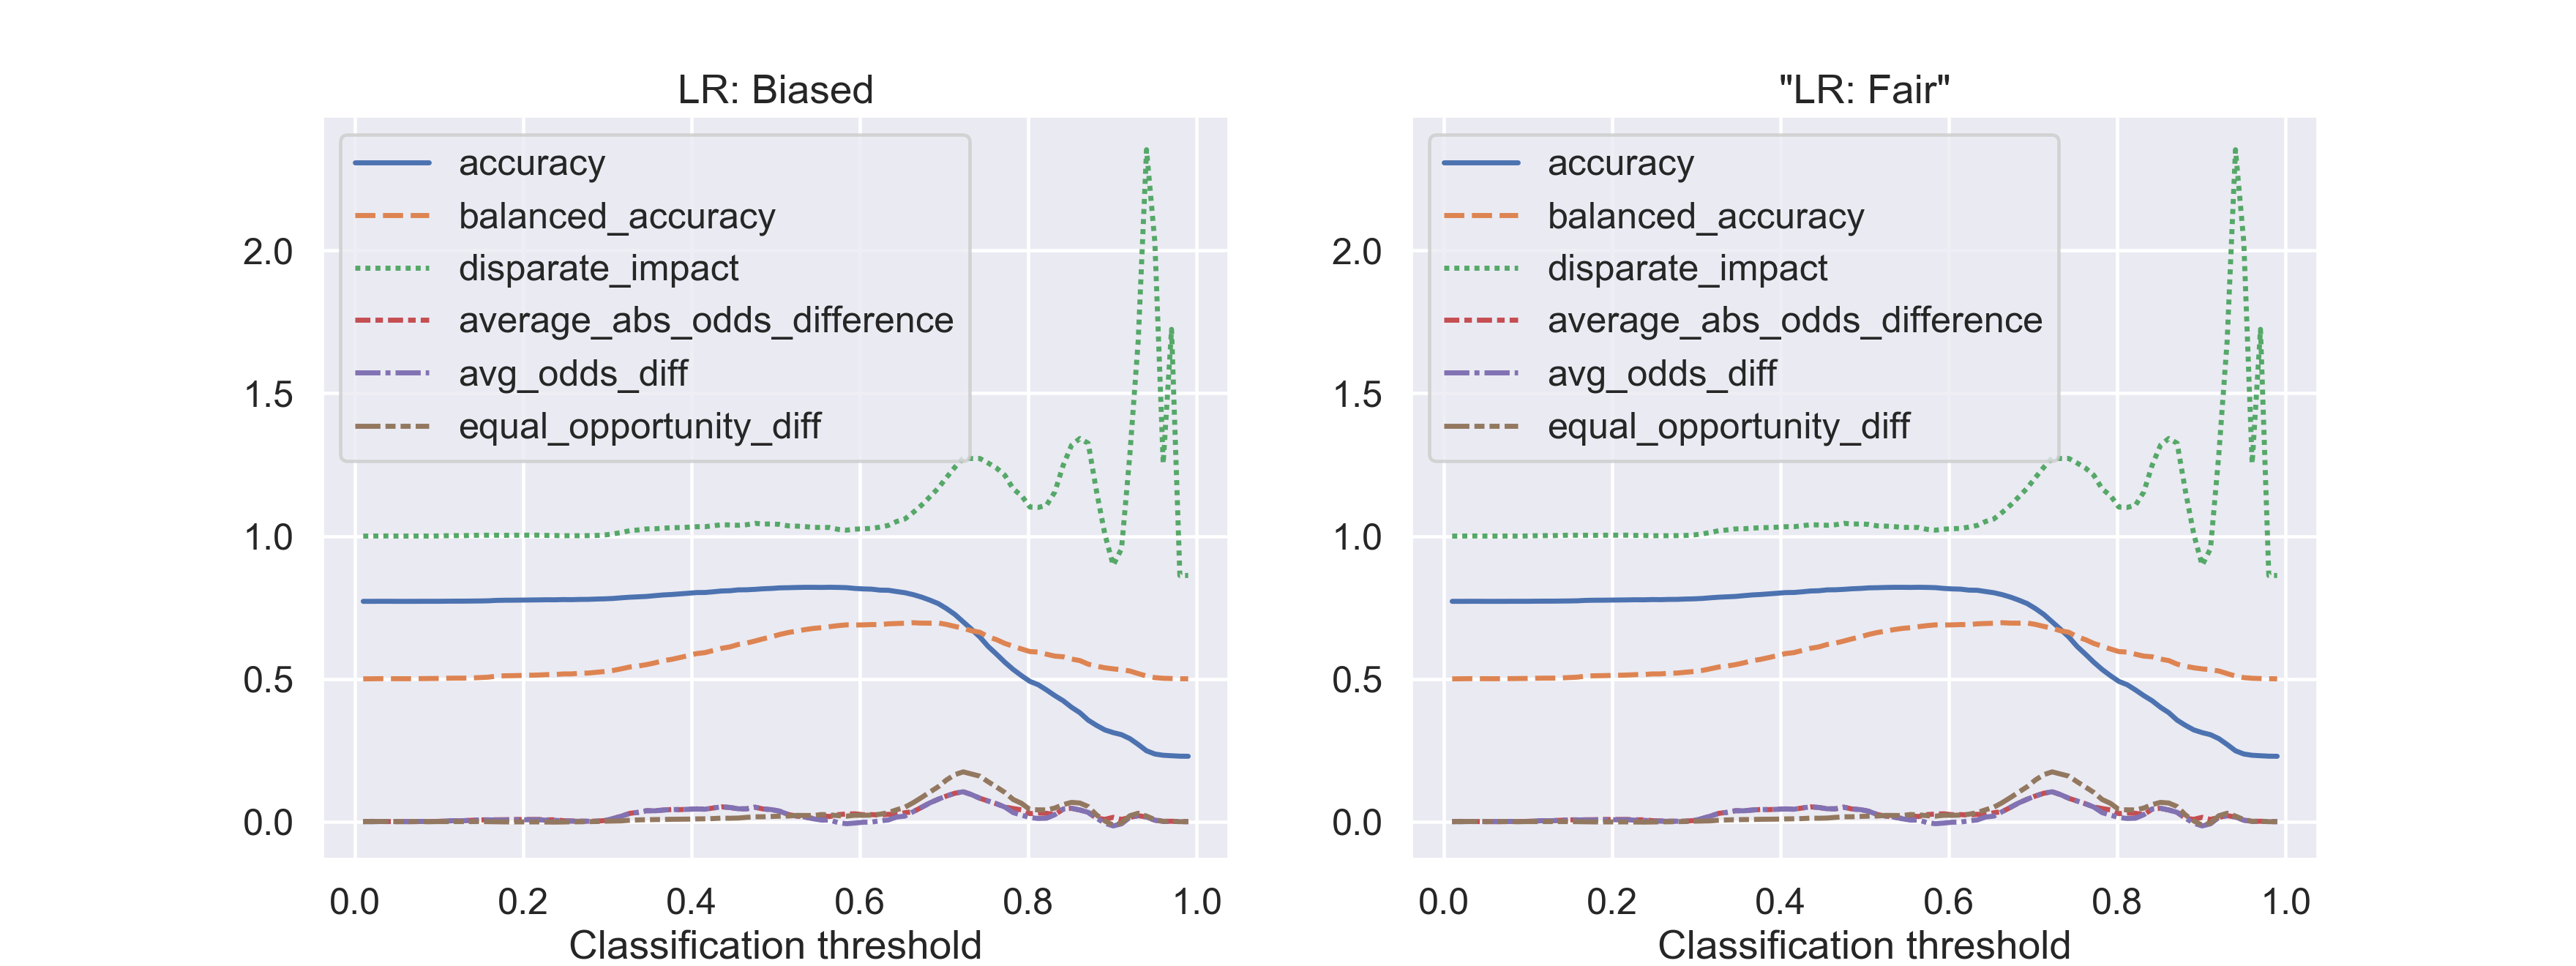

In [32]:
# Plot for LR
fig, ax = plt.subplots(nrows=1, 
                       ncols=2,
                       figsize=(16,6))
with warnings.catch_warnings():
     warnings.simplefilter('ignore', RuntimeWarning)
    
     plot_metrics(calc_metrics(biasedlogmodel, X_test, y_test),
                ax=ax[0],
                title="LR: Biased")
    
     plot_metrics(calc_metrics(unbiasedlogmodel, X_di_test, y_di_test),
                ax=ax[1],
                title='"LR: Fair"')

<IPython.core.display.Javascript object>


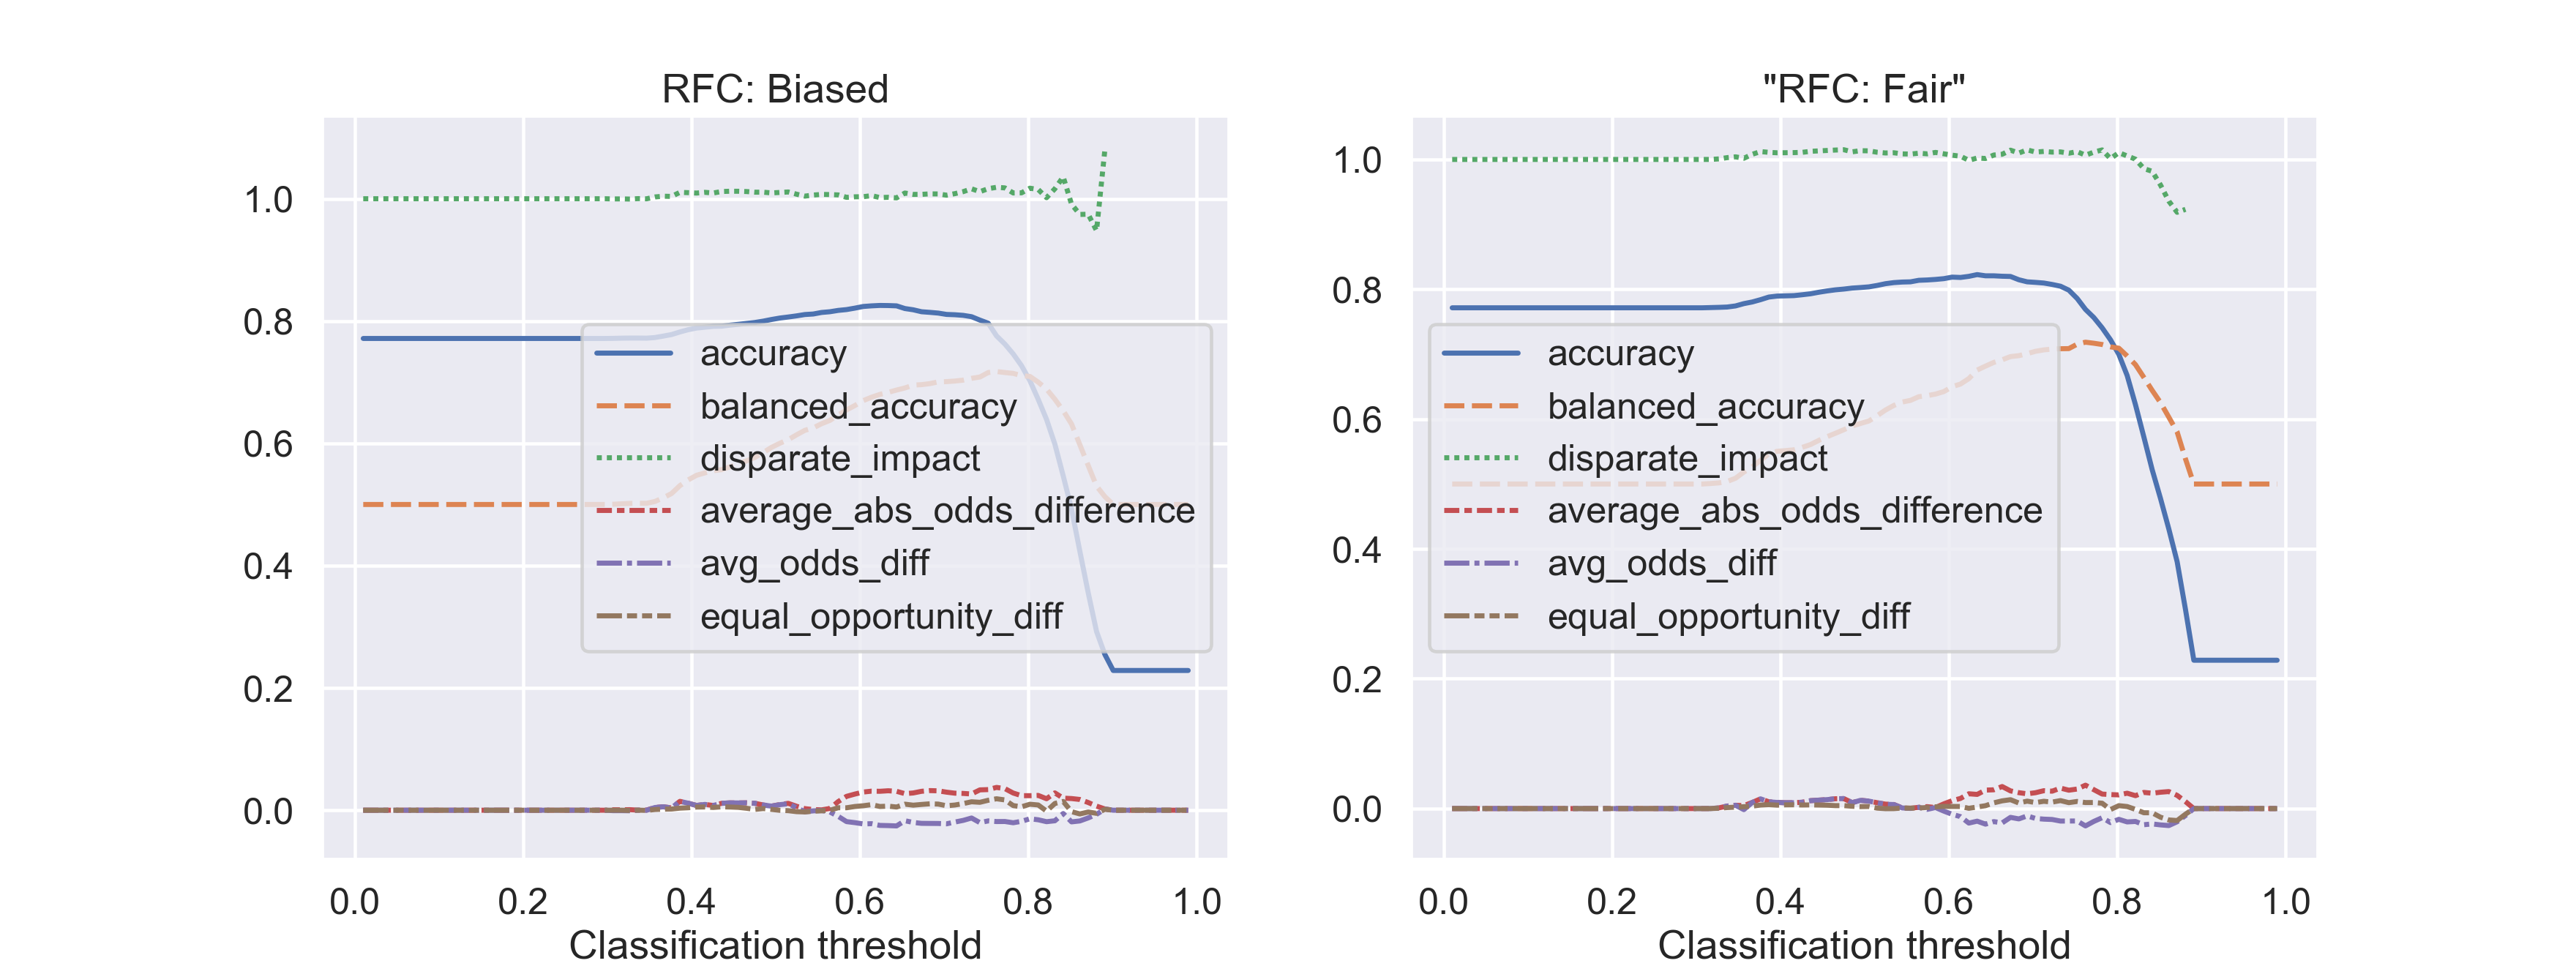

In [33]:
# Plot for RFC
fig, ax = plt.subplots(nrows=1, 
                       ncols=2,
                       figsize=(16, 6))
with warnings.catch_warnings():
    warnings.simplefilter('ignore', RuntimeWarning)
    
    plot_metrics(calc_metrics(biasedrfcmodel, X_test, y_test),
                ax=ax[0],
                title="RFC: Biased")
    
    plot_metrics(calc_metrics(unbiasedrfcmodel, X_di_test, y_di_test),
                ax=ax[1],
                title='"RFC: Fair"')

In [34]:
# Now test whether it is possible to predict the Protected Variable from the DI-removed transformed dataset
# Test whether we can predict the Sensitive (Protected) variable from the transformed training dataset
Xdi = Taiwan_di_removed_df.drop(protected_attr,axis=1)
ydi = Taiwan_di_removed_df[protected_attr]
X_di_train, X_di_test, y_di_train, y_di_test = train_test_split(Xdi, ydi, test_size = 0.2, random_state = 101)
debiasedLogModel = LogisticRegression(random_state=101)
debiasedRfcModel = RandomForestClassifier(n_estimators=100,max_depth=4,random_state=101)
debiasedLogModel.fit(X_di_train, y_di_train) 
debiasedRfcModel.fit(X_di_train, y_di_train) 
# Now test whether we can predict Gender from the test dataset
print(f"Logistic regression validation accuracy: {debiasedLogModel.score(X_di_test, y_di_test)}")
print(f"Random Forest       validation accuracy: {debiasedRfcModel.score(X_di_test, y_di_test)}")

Logistic regression validation accuracy: 0.7157805907172996
Random Forest       validation accuracy: 0.7355274261603375
